### United States Real Estate Analysis ###

Please Note: Our primary csv for real estate data contained more than 2M datapoints and was significantly larger than GitHub allowed (170.57 MB). As such, we trimmed down our dataset logically with the following code prior to upload:

-Removed unnecessay columns (Brokered By & Street) by only including columns of interest: dataframe = dataframe[["status", "price", "bed", "bath", "acre_lot", "city", "state", "zip_code", "house_size", "prev_sold_date"]]

-Removed U.S. Territories (Puerto Rico & Virgin Islands) to only include states within our analysis: dataframe = dataframe.loc[(dataframe["state"] != "Puerto Rico") & (dataframe["state"] != "Virgin Islands")]

In [1]:
# Import appropriate dependencies
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
from scipy.stats import linregress
from scipy.stats import normaltest
import time


# Establish proper filepath to csv file
filepath = "Resources/real_estate.csv"

# Read csv file into initial dataframe and display
initial_dataset_df = pd.read_csv(filepath)
initial_dataset_df


,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
0,for_sale,525000,3,3,0.45,Agawam,Massachusetts,1001,2314,6/25/14
1,for_sale,289900,3,2,0.36,Agawam,Massachusetts,1001,1276,10/12/12
2,for_sale,384900,3,2,0.46,Agawam,Massachusetts,1001,1476,11/20/86
3,for_sale,199999,3,2,1.76,Agawam,Massachusetts,1001,1968,9/19/08
4,for_sale,419000,4,2,2.00,Pelham,Massachusetts,1002,1607,7/25/05
...,...,...,...,...,...,...,...,...,...,...
1048570,sold,520000,3,3,0.09,Newberg,Oregon,97132,1630,2/18/22
1048571,sold,635000,5,3,0.14,Beaverton,Oregon,97007,2618,2/18/22
1048572,sold,749000,4,2,0.20,Wilsonville,Oregon,97070,2492,2/18/22
1048573,sold,485000,3,2,0.13,Newberg,Oregon,97132,1364,2/18/22


In [2]:
# First, we should locate if there are any duplicate entries within our dataset
initial_dataset_df.duplicated().sum()


1216

In [3]:
# Drop the 1,216 duplicate values from our dataframe
initial_dataset_df.drop_duplicates(inplace=True)


In [4]:
# Confirm new count of rows minus the removed duplicate datapoints
initial_dataset_df.count()


status            1047359
price             1047359
bed               1047359
bath              1047359
acre_lot          1047359
city              1047359
state             1047359
zip_code          1047359
house_size        1047359
prev_sold_date    1047359
dtype: int64

In [5]:
# Coverting date format to datetime within pandas
initial_dataset_df['prev_sold_date'] = pd.to_datetime(initial_dataset_df['prev_sold_date'], format='%m/%d/%y')


In [6]:
# Display updated dataframe
initial_dataset_df

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
0,for_sale,525000,3,3,0.45,Agawam,Massachusetts,1001,2314,2014-06-25
1,for_sale,289900,3,2,0.36,Agawam,Massachusetts,1001,1276,2012-10-12
2,for_sale,384900,3,2,0.46,Agawam,Massachusetts,1001,1476,1986-11-20
3,for_sale,199999,3,2,1.76,Agawam,Massachusetts,1001,1968,2008-09-19
4,for_sale,419000,4,2,2.00,Pelham,Massachusetts,1002,1607,2005-07-25
...,...,...,...,...,...,...,...,...,...,...
1048570,sold,520000,3,3,0.09,Newberg,Oregon,97132,1630,2022-02-18
1048571,sold,635000,5,3,0.14,Beaverton,Oregon,97007,2618,2022-02-18
1048572,sold,749000,4,2,0.20,Wilsonville,Oregon,97070,2492,2022-02-18
1048573,sold,485000,3,2,0.13,Newberg,Oregon,97132,1364,2022-02-18


In [7]:
# Filtering number of bedroom to less than or equal to 5 & dates after 2015
filtered_df = initial_dataset_df.loc[(initial_dataset_df['bed'] <= 5) & (initial_dataset_df['prev_sold_date'] > "2015-01-01")]

In [8]:
# Splitting dataset into three distinct individual states for analysis (East US / Central US/ West US)
pa_df = initial_dataset_df.loc[(initial_dataset_df['state'] == "Pennsylvania")]
wi_df = initial_dataset_df.loc[(initial_dataset_df['state'] == "Wisconsin")]
wa_df = initial_dataset_df.loc[(initial_dataset_df['state'] == "Washington")]

In [9]:
# Display Pennsylvania dataframe
pa_df

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
18640,for_sale,279900,3,3,1.14,Lower Mt Bethel Township,Pennsylvania,18013,1865,2017-08-01
18641,for_sale,129900,3,1,0.56,East Stroudsburg,Pennsylvania,18301,1050,1970-11-10
18643,for_sale,189900,2,3,0.03,Stroudsburg,Pennsylvania,18360,1230,2005-04-01
18645,for_sale,259900,3,2,0.13,East Stroudsburg,Pennsylvania,18301,1306,2021-09-03
18646,for_sale,135900,3,1,0.09,Bangor,Pennsylvania,18013,904,2019-03-26
...,...,...,...,...,...,...,...,...,...,...
727642,sold,210000,3,2,0.50,Beaver Falls,Pennsylvania,15010,2016,2022-04-22
727644,sold,219000,7,4,0.16,New Brighton,Pennsylvania,15066,5600,2022-04-21
727784,sold,169900,2,1,1.09,New Castle,Pennsylvania,16105,1165,2021-11-09
727813,sold,255000,4,3,0.46,New Castle,Pennsylvania,16105,2450,2022-01-20


In [10]:
# Display Washington dataframe
wa_df

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
365274,for_sale,282000,4,2,0.32,Clarkston,Washington,99403,1628,2007-01-31
365275,for_sale,490000,3,2,0.42,Clarkston,Washington,99403,1789,2006-04-18
365278,for_sale,479000,4,4,0.24,Clarkston,Washington,99403,2652,2007-06-04
365279,for_sale,550000,4,3,0.27,Clarkston,Washington,99403,2510,2015-04-17
365281,for_sale,649000,4,2,0.27,Asotin,Washington,99402,1623,2021-01-07
...,...,...,...,...,...,...,...,...,...,...
1046588,sold,60000,2,1,0.26,Wishram,Washington,98673,1160,2022-01-13
1046653,sold,314370,3,2,5.07,Goldendale,Washington,98620,1763,2022-04-27
1046701,sold,410000,3,2,0.55,Dallesport,Washington,98617,1809,2021-11-22
1046703,sold,250000,2,2,45.00,Goldendale,Washington,98620,924,2021-11-19


In [11]:
# Display Wisconsin dataframe
wi_df

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
238260,for_sale,179900,2,1,2.00,Pembine,Wisconsin,54156,1248,2020-08-20
238305,for_sale,239900,3,2,26.37,Pembine,Wisconsin,54156,1630,2017-04-13
238307,for_sale,179900,3,2,1.10,Pembine,Wisconsin,54156,1824,2004-07-29
238309,for_sale,320000,3,2,36.99,Wausaukee,Wisconsin,54177,1626,2003-04-08
238310,for_sale,339000,3,2,2.54,Florence,Wisconsin,54121,1684,2017-06-12
...,...,...,...,...,...,...,...,...,...,...
785402,sold,79900,3,2,0.26,Janesville,Wisconsin,53548,1588,2022-03-25
785403,sold,115000,3,2,0.14,Beloit,Wisconsin,53511,1006,2022-03-25
785404,sold,262500,2,2,0.26,Janesville,Wisconsin,53545,1215,2022-04-08
785405,sold,149900,2,2,0.17,Beloit,Wisconsin,53511,1092,2022-04-08


In [12]:
#Clean data for Wisconsin

# Determine and eliminate price outliers within the Wisconsin dataframe via IQR range/bound calculations
upper_q3 = wi_df['price'].quantile(0.75)
lower_q1 = wi_df['price'].quantile(0.25)
iqr = upper_q3 - lower_q1
upper_bound = upper_q3 + (1.5 * iqr)
lower_bound = lower_q1 - (1.5 * iqr)
wi_df_clean = wi_df[(wi_df['price'] <= upper_bound) & (wi_df['price'] >= lower_bound)]
# Exclude rows where listing price is less than $5,000 to eliminate incorrect datapoints due to data entry error
wi_df_clean = wi_df_clean[wi_df_clean['price'] > 5000]
wi_df_clean
# 12,985 rows minus this new dataframe's rows 12,352 = the number of removed rows with outlier prices/less than $5,000 (633)


,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
238260,for_sale,179900,2,1,2.00,Pembine,Wisconsin,54156,1248,2020-08-20
238305,for_sale,239900,3,2,26.37,Pembine,Wisconsin,54156,1630,2017-04-13
238307,for_sale,179900,3,2,1.10,Pembine,Wisconsin,54156,1824,2004-07-29
238309,for_sale,320000,3,2,36.99,Wausaukee,Wisconsin,54177,1626,2003-04-08
238310,for_sale,339000,3,2,2.54,Florence,Wisconsin,54121,1684,2017-06-12
...,...,...,...,...,...,...,...,...,...,...
785402,sold,79900,3,2,0.26,Janesville,Wisconsin,53548,1588,2022-03-25
785403,sold,115000,3,2,0.14,Beloit,Wisconsin,53511,1006,2022-03-25
785404,sold,262500,2,2,0.26,Janesville,Wisconsin,53545,1215,2022-04-08
785405,sold,149900,2,2,0.17,Beloit,Wisconsin,53511,1092,2022-04-08


In [13]:
#Clean data for Washington

# Determine and eliminate price outliers within the Washington dataframe via IQR range/bound calculations
upper_q3 = wa_df['price'].quantile(0.75)
lower_q1 = wa_df['price'].quantile(0.25)
iqr = upper_q3 - lower_q1
upper_bound = upper_q3 + (1.5 * iqr)
lower_bound = lower_q1 - (1.5 * iqr)
wa_df_clean = wa_df[(wa_df['price'] <= upper_bound) & (wa_df['price'] >= lower_bound)]
# Exclude rows where listing price is less than $5,000 to eliminate incorrect datapoints due to data entry error
wa_df_clean = wa_df_clean[wa_df_clean['price'] > 5000]
wa_df_clean
# 11,781 rows minus this new dataframe's rows 10,883 = the number of removed rows with outlier prices/less than $5,000 (898)


,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
365274,for_sale,282000,4,2,0.32,Clarkston,Washington,99403,1628,2007-01-31
365275,for_sale,490000,3,2,0.42,Clarkston,Washington,99403,1789,2006-04-18
365278,for_sale,479000,4,4,0.24,Clarkston,Washington,99403,2652,2007-06-04
365279,for_sale,550000,4,3,0.27,Clarkston,Washington,99403,2510,2015-04-17
365281,for_sale,649000,4,2,0.27,Asotin,Washington,99402,1623,2021-01-07
...,...,...,...,...,...,...,...,...,...,...
1046588,sold,60000,2,1,0.26,Wishram,Washington,98673,1160,2022-01-13
1046653,sold,314370,3,2,5.07,Goldendale,Washington,98620,1763,2022-04-27
1046701,sold,410000,3,2,0.55,Dallesport,Washington,98617,1809,2021-11-22
1046703,sold,250000,2,2,45.00,Goldendale,Washington,98620,924,2021-11-19


In [14]:
#Clean data for Pennsylvania

# Determine and eliminate price outliers within the Pennsylvania dataframe via IQR range/bound calculations
upper_q3 = pa_df['price'].quantile(0.75)
lower_q1 = pa_df['price'].quantile(0.25)
iqr = upper_q3 - lower_q1
upper_bound = upper_q3 + (1.5 * iqr)
lower_bound = lower_q1 - (1.5 * iqr)
pa_df_clean = pa_df[(pa_df['price'] <= upper_bound) & (pa_df['price'] >= lower_bound)]
# Exclude rows where listing price is less than $5,000 to eliminate incorrect datapoints due to data entry error
pa_df_clean = pa_df_clean[pa_df_clean['price'] > 5000]
pa_df_clean
# 42,628 rows minus this new dataframe's rows 40,057 = the number of removed rows with outlier prices/less than $5,000 (2,571)


,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
18640,for_sale,279900,3,3,1.14,Lower Mt Bethel Township,Pennsylvania,18013,1865,2017-08-01
18641,for_sale,129900,3,1,0.56,East Stroudsburg,Pennsylvania,18301,1050,1970-11-10
18643,for_sale,189900,2,3,0.03,Stroudsburg,Pennsylvania,18360,1230,2005-04-01
18645,for_sale,259900,3,2,0.13,East Stroudsburg,Pennsylvania,18301,1306,2021-09-03
18646,for_sale,135900,3,1,0.09,Bangor,Pennsylvania,18013,904,2019-03-26
...,...,...,...,...,...,...,...,...,...,...
727635,sold,325000,4,3,1.25,Ellwood City,Pennsylvania,16117,2028,2022-03-01
727642,sold,210000,3,2,0.50,Beaver Falls,Pennsylvania,15010,2016,2022-04-22
727644,sold,219000,7,4,0.16,New Brighton,Pennsylvania,15066,5600,2022-04-21
727784,sold,169900,2,1,1.09,New Castle,Pennsylvania,16105,1165,2021-11-09


In [15]:
#Number of houses Sold or for_sale for all 3 States
# Count the number of houses sold and for sale - Washington
houses_sold_wa = wa_df_clean[wa_df_clean['status'] == 'sold'].shape[0]
houses_for_sale_wa = wa_df_clean[wa_df_clean['status'] == 'for_sale'].shape[0]

print("Number of houses sold in Washington:", houses_sold_wa)
print("Number of houses for sale in Washington:", houses_for_sale_wa)


# Count the number of houses sold and for sale -Wisconsin
houses_sold_wi = wi_df_clean[wi_df_clean['status'] == 'sold'].shape[0]
houses_for_sale_wi = wi_df_clean[wi_df_clean['status'] == 'for_sale'].shape[0]

print("Number of houses sold in Wisconsin:", houses_sold_wi)
print("Number of houses for sale in Wisconsin:", houses_for_sale_wi)


# Count the number of houses sold and for sale - Pennsylvania
houses_sold_pa = pa_df_clean[pa_df_clean['status'] == 'sold'].shape[0]
houses_for_sale_pa = pa_df_clean[pa_df_clean['status'] == 'for_sale'].shape[0]

print("Number of houses sold in Pennsylvania:", houses_sold_pa)
print("Number of houses for sale in Pennsylvania:", houses_for_sale_pa)

Number of houses sold in Washington: 292
Number of houses for sale in Washington: 10591
Number of houses sold in Wisconsin: 6805
Number of houses for sale in Wisconsin: 5547
Number of houses sold in Pennsylvania: 22120
Number of houses for sale in Pennsylvania: 17937


In [16]:
#Cities with Highest Number of House Sold in all 3 States

# Group by city and count the number of houses sold in each city of Washington
houses_sold_by_wa = wa_df_clean[wa_df_clean['status'] == 'sold'].groupby('city').size()
wa_with_most_sales = houses_sold_by_wa.idxmax()
num_sales_in_wa = houses_sold_by_wa.max()

print("City with the highest number of houses sold in Washington:", wa_with_most_sales)
print("Number of houses sold in", wa_with_most_sales + ":", num_sales_in_wa)

# Group by city and count the number of houses sold in each Wisconsin
houses_sold_by_wi = wi_df_clean[wi_df_clean['status'] == 'sold'].groupby('city').size()
wi_with_most_sales = houses_sold_by_wi.idxmax()
num_sales_in_wi = houses_sold_by_wi.max()

print("City with the highest number of houses sold in Wisconsin:", wi_with_most_sales)
print("Number of houses sold in", wi_with_most_sales + ":", num_sales_in_wi)

# Group by city and count the number of houses sold in each city in Pennsylvania
houses_sold_by_pa = pa_df_clean[pa_df_clean['status'] == 'sold'].groupby('city').size()
pa_with_most_sales = houses_sold_by_pa.idxmax()
num_sales_in_pa = houses_sold_by_pa.max()

print("City with the highest number of houses sold in Pennsylvania:", pa_with_most_sales)
print("Number of houses sold in", pa_with_most_sales + ":", num_sales_in_pa)


City with the highest number of houses sold in Washington: Spokane Valley
Number of houses sold in Spokane Valley: 113
City with the highest number of houses sold in Wisconsin: Madison
Number of houses sold in Madison: 491
City with the highest number of houses sold in Pennsylvania: Philadelphia
Number of houses sold in Philadelphia: 1638


In [17]:
#Costliest top 5 houses in each state

# Sort by price descending and select top 5 in state of Washington
top_5_costliest_wa = wa_df_clean.nlargest(5, 'price')

print("Top 5 costliest houses in Washington:")
print(top_5_costliest_wa[['city', 'price']])

# Sort by price descending and select top 5 in state of Wisconsin
top_5_costliest_wi = wi_df_clean.nlargest(5, 'price')

print("Top 5 costliest houses in Wisconsin:")
print(top_5_costliest_wi[['city', 'price']])


# Sort by price descending and select top 5 in state of Pennsylvania
top_5_costliest_pa = pa_df_clean.nlargest(5, 'price')

print("Top 5 costliest houses in Pannsylvania:")
print(top_5_costliest_pa[['city', 'price']])

Top 5 costliest houses in Washington:
              city    price
467652     Bothell  1539000
472339  Bellingham  1532000
468039   Sammamish  1525000
468403    Issaquah  1525000
468738      Renton  1525000
Top 5 costliest houses in Wisconsin:
              city   price
246258   Shorewood  694900
245207    Hartland  694000
252686     Exeland  692600
246355  Oconomowoc  689900
247168  Burlington  689900
Top 5 costliest houses in Pannsylvania:
                city   price
27103      Bryn Mawr  719900
29044    Elkins Park  719900
61648       Chalfont  719900
509997       Ardmore  719900
510327  Philadelphia  719900


In [18]:
#Cheapest bottom 5 houses in  each state

# Sort by price ascending and select top 5 in Washington
bottom_5_cheapest_wa = wa_df_clean.nsmallest(5, 'price')

print("Bottom 5 cheapest houses in Washington:")
print(bottom_5_cheapest_wa[['city', 'price']])


# Sort by price ascending and select top 5 in Wisconsin
bottom_5_cheapest_wi = wi_df_clean.nsmallest(5, 'price')

print("Bottom 5 cheapest houses in Wisconsin:")
print(bottom_5_cheapest_wi[['city', 'price']])


# Sort by price ascending and select top 5 in Pennsylvania
bottom_5_cheapest_pa = pa_df_clean.nsmallest(5, 'price')

print("Bottom 5 cheapest houses in Pennsylvania:")
print(bottom_5_cheapest_pa[['city', 'price']])


Bottom 5 cheapest houses in Washington:
                city  price
902314     Clarkston  47900
476545       Spokane  50000
473193   Maple Falls  54500
472873        Deming  56500
1046588      Wishram  60000
Bottom 5 cheapest houses in Wisconsin:
            city  price
753447     Mason   9900
753128    Mellen  18900
747323    Beloit  19000
785381    Beloit  19000
252342  Rib Lake  19900
Bottom 5 cheapest houses in Pennsylvania:
                   city  price
51039  Northern Cambria   6500
50749         Johnstown   9200
48840           Freedom   9900
50773         Johnstown   9900
51319          Franklin   9900


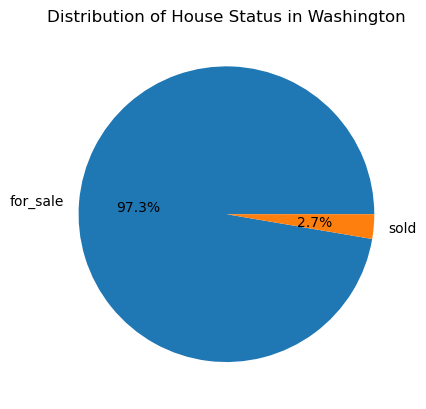

In [19]:
#Pie Chart of Status of Houses in all 3 States

# Count the number of houses by status for Washington
status_counts_wa = wa_df_clean['status'].value_counts()

# Plot pie chart
status_counts_wa.plot(kind='pie', autopct='%1.1f%%', title='Distribution of House Status in Washington')
plt.ylabel('')
plt.savefig("image_files_2/wa_pc.png")
plt.show()


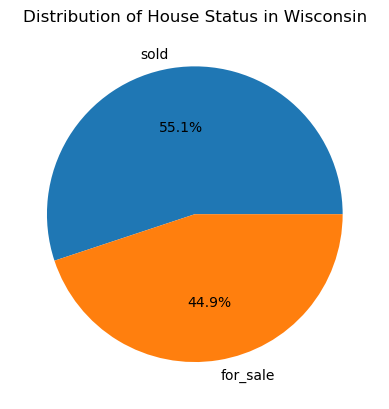

In [20]:
#Pie Chart of Status of Houses in all 3 States

# Count the number of houses by status for Wisconsin
status_counts_wi = wi_df_clean['status'].value_counts()

# Plot pie chart
status_counts_wi.plot(kind='pie', autopct='%1.1f%%', title='Distribution of House Status in Wisconsin')
plt.ylabel('')
plt.savefig("image_files_2/wi_pc.png")
plt.show()


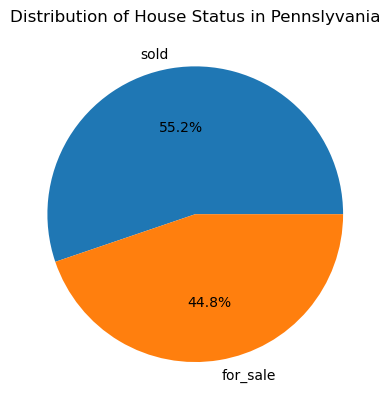

In [21]:
#Pie Chart of Status of Houses in all 3 States

# Count the number of houses by status for Pennslyvania
status_counts_pa = pa_df_clean['status'].value_counts()

# Plot pie chart
status_counts_pa.plot(kind='pie', autopct='%1.1f%%', title='Distribution of House Status in Pennslyvania')
plt.ylabel('')
plt.savefig("image_files_2/pa_pc.png")
plt.show()


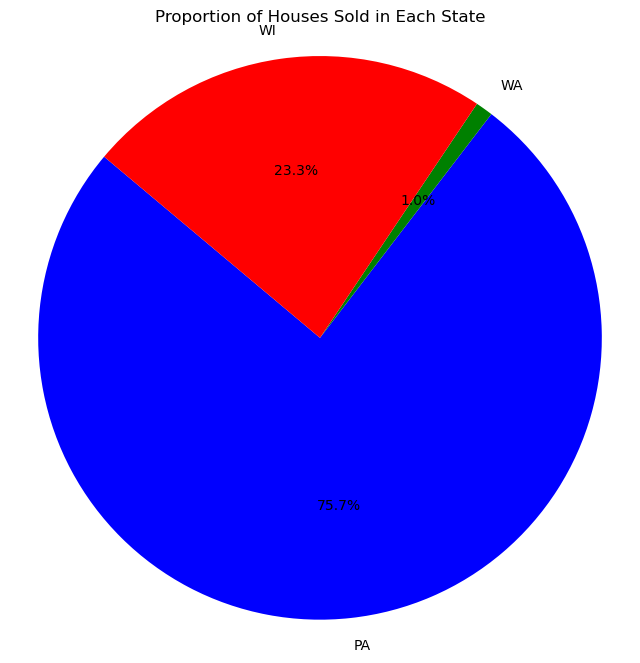

In [22]:
#Collective Pie Chart for houses sold in all 3 states

# Filter data for houses sold
pa_sold = pa_df_clean[pa_df_clean['status'] == 'sold']
wa_sold = wa_df_clean[wa_df_clean['status'] == 'sold']
wi_sold = wi_df_clean[wi_df_clean['status'] == 'sold']

# Calculate the total number of houses sold in each state
total_sold_pa = pa_sold.shape[0]
total_sold_wa = wa_sold.shape[0]
total_sold_wi = wi_sold.shape[0]

# Create a DataFrame for the total houses sold
total_sold = pd.DataFrame({
    'State': ['PA', 'WA', 'WI'],
    'Total Houses Sold': [total_sold_pa, total_sold_wa, total_sold_wi]
})

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(total_sold['Total Houses Sold'], labels=total_sold['State'], autopct='%1.1f%%', colors=['blue', 'green', 'red'], startangle=140)
plt.title('Proportion of Houses Sold in Each State')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("image_files_2/sold_pc.png")
plt.show()

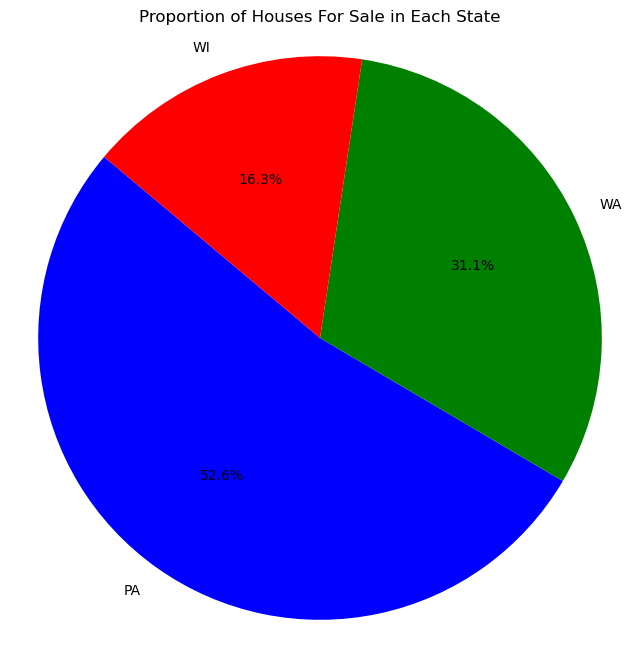

In [23]:
# Collective Pie Chart for houses For_sale in all 3 states

# Filter data for houses for sale
pa_for_sale = pa_df_clean[pa_df_clean['status'] == 'for_sale']
wa_for_sale = wa_df_clean[wa_df_clean['status'] == 'for_sale']
wi_for_sale = wi_df_clean[wi_df_clean['status'] == 'for_sale']

# Calculate the total number of houses for sale in each state
total_for_sale_pa = pa_for_sale.shape[0]
total_for_sale_wa = wa_for_sale.shape[0]
total_for_sale_wi = wi_for_sale.shape[0]

# Create a DataFrame for the total houses for sale
total_for_sale = pd.DataFrame({
    'State': ['PA', 'WA', 'WI'],
    'Total Houses For Sale': [total_for_sale_pa, total_for_sale_wa, total_for_sale_wi]
})

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(total_for_sale['Total Houses For Sale'], labels=total_for_sale['State'], autopct='%1.1f%%', colors=['blue', 'green', 'red'], startangle=140)
plt.title('Proportion of Houses For Sale in Each State')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("image_files_2/for_sale_pc.png")
plt.show()

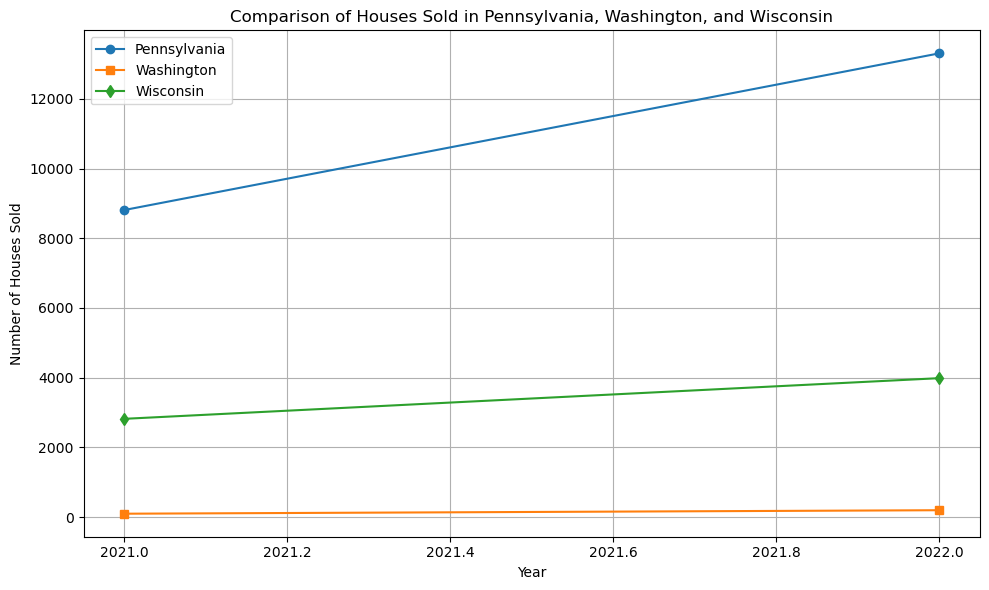

Correlation between houses sold in Pennsylvania and Washington: 0.9999999999999998
Correlation between houses sold in Pennsylvania and Wisconsin: 1.0
Correlation between houses sold in Washington and Wisconsin: 1.0
Pennsylvania - Highest Price Sold: 719900
Pennsylvania - Lowest Price Sold: 12900
Washington - Highest Price Sold: 1495000
Washington - Lowest Price Sold: 47900
Wisconsin - Highest Price Sold: 689900
Wisconsin - Lowest Price Sold: 9900


In [24]:
#Comparison of Houses Sold in 3 States
# Filter datasets for houses sold
pa_df_sold = pa_df_clean[pa_df_clean['status'] == 'sold']
wa_df_sold = wa_df_clean[wa_df_clean['status'] == 'sold']
wi_df_sold = wi_df_clean[wi_df_clean['status'] == 'sold']

# Group by year and count the number of houses sold in each state
pa_houses_sold_by_year = pa_df_sold['prev_sold_date'].dt.year.value_counts().sort_index()
wa_houses_sold_by_year = wa_df_sold['prev_sold_date'].dt.year.value_counts().sort_index()
wi_houses_sold_by_year = wi_df_sold['prev_sold_date'].dt.year.value_counts().sort_index()

# Plotting the line chart to compare houses sold in each state over time
plt.figure(figsize=(10, 6))
plt.plot(pa_houses_sold_by_year.index, pa_houses_sold_by_year.values, label='Pennsylvania', marker='o')
plt.plot(wa_houses_sold_by_year.index, wa_houses_sold_by_year.values, label='Washington', marker='s')
plt.plot(wi_houses_sold_by_year.index, wi_houses_sold_by_year.values, label='Wisconsin', marker='d')
plt.xlabel('Year')
plt.ylabel('Number of Houses Sold')
plt.title('Comparison of Houses Sold in Pennsylvania, Washington, and Wisconsin')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("image_files_2/sold_lc.png")
plt.show()

# Calculate correlation between the number of houses sold in pa_df, wa_df, and wi_df
correlation = pa_houses_sold_by_year.corr(wa_houses_sold_by_year)
print("Correlation between houses sold in Pennsylvania and Washington:", correlation)

correlation = pa_houses_sold_by_year.corr(wi_houses_sold_by_year)
print("Correlation between houses sold in Pennsylvania and Wisconsin:", correlation)

correlation = wa_houses_sold_by_year.corr(wi_houses_sold_by_year)
print("Correlation between houses sold in Washington and Wisconsin:", correlation)

# Find highest and lowest prices of houses sold in each state
pa_highest_price = pa_df_sold['price'].max()
pa_lowest_price = pa_df_sold['price'].min()

wa_highest_price = wa_df_sold['price'].max()
wa_lowest_price = wa_df_sold['price'].min()

wi_highest_price = wi_df_sold['price'].max()
wi_lowest_price = wi_df_sold['price'].min()

print("Pennsylvania - Highest Price Sold:", pa_highest_price)
print("Pennsylvania - Lowest Price Sold:", pa_lowest_price)

print("Washington - Highest Price Sold:", wa_highest_price)
print("Washington - Lowest Price Sold:", wa_lowest_price)

print("Wisconsin - Highest Price Sold:", wi_highest_price)
print("Wisconsin - Lowest Price Sold:", wi_lowest_price)

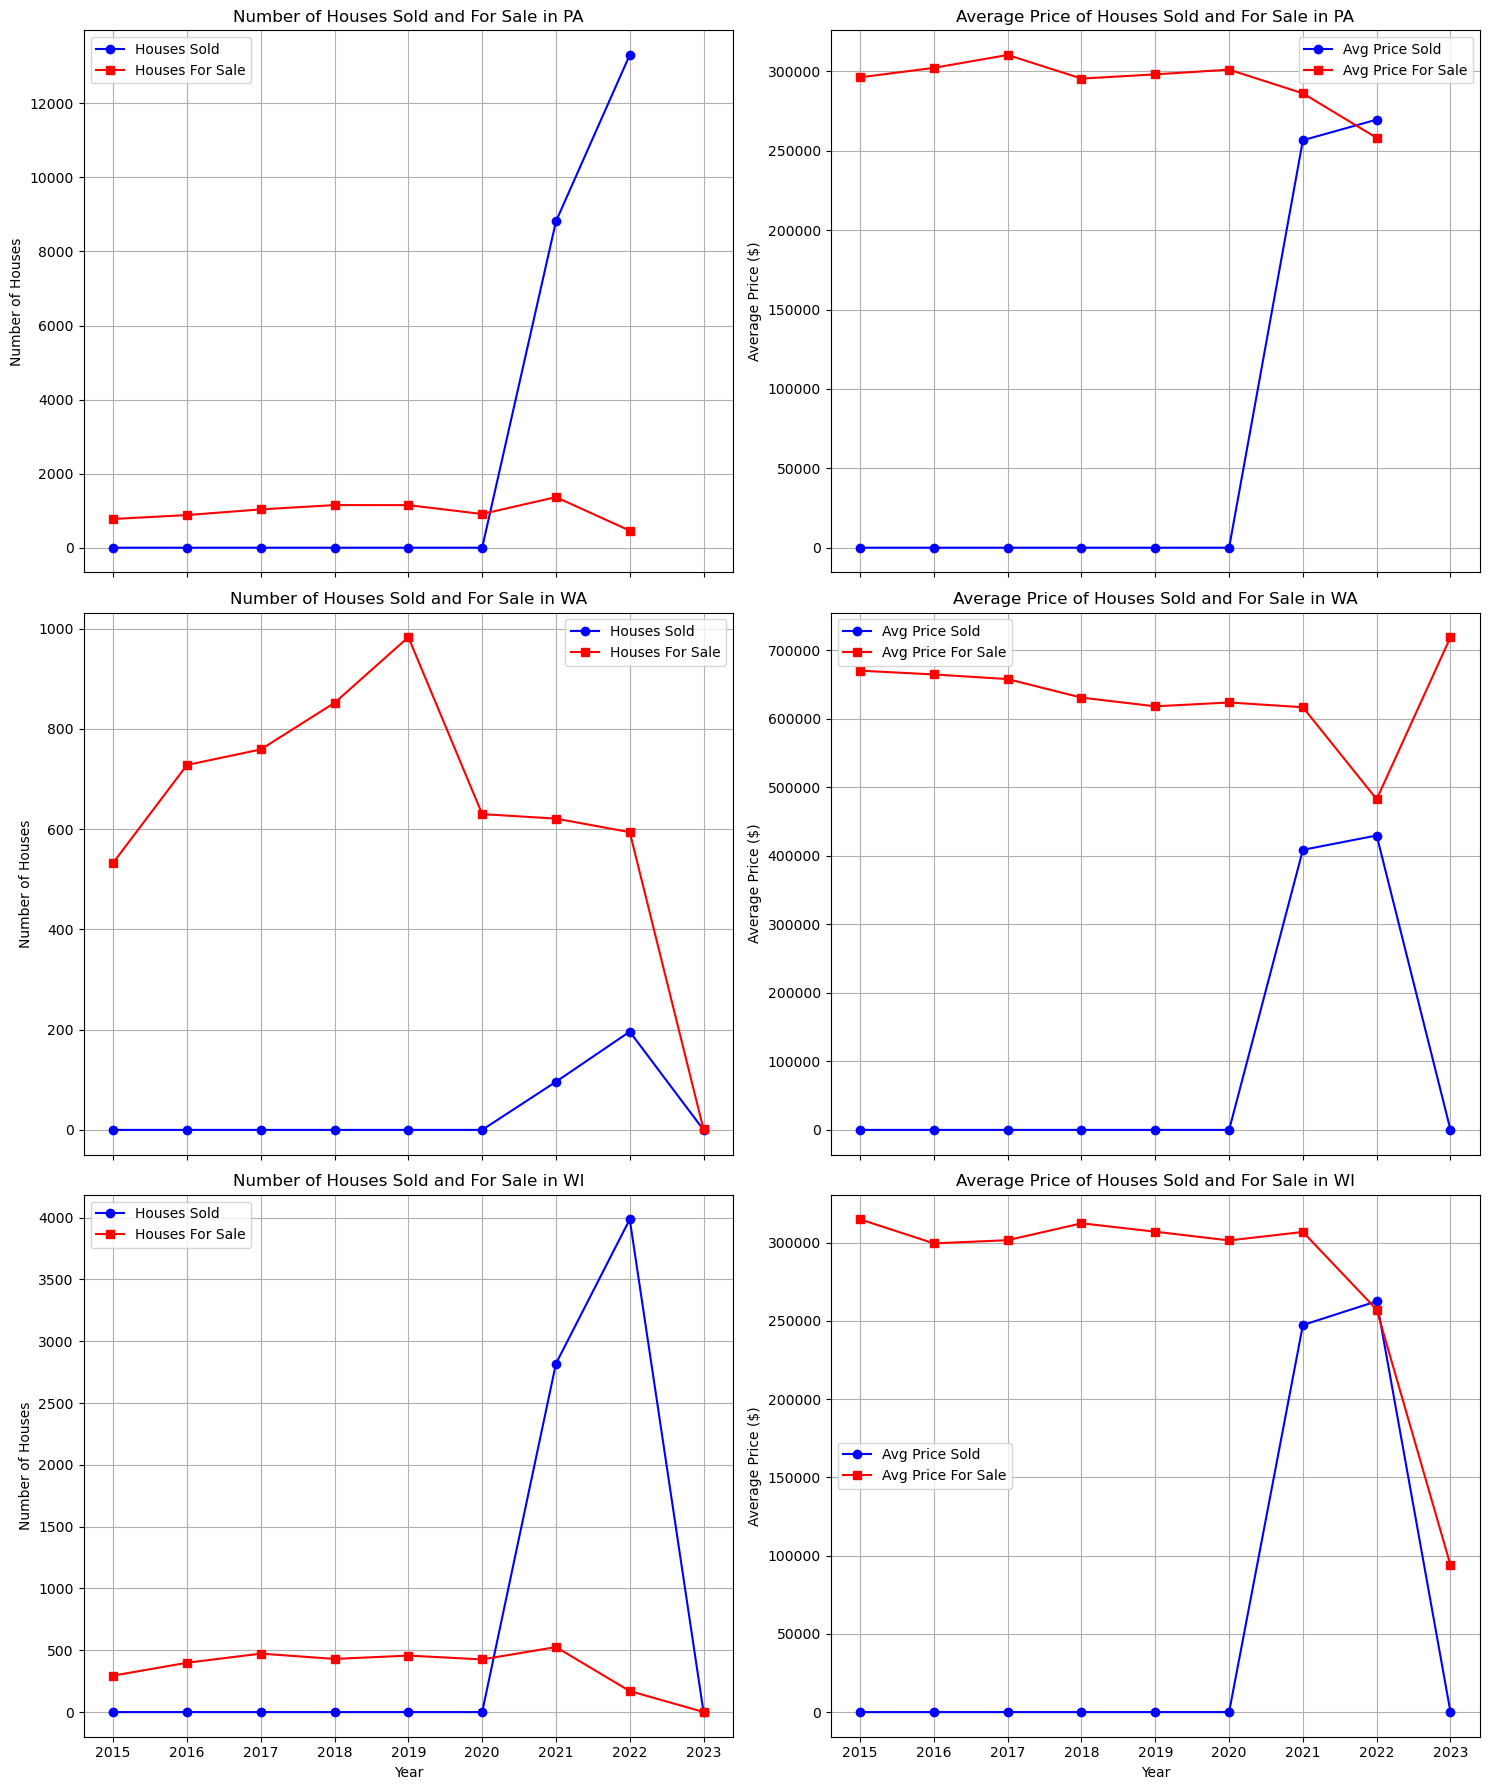

In [25]:
#All three states - houses sold and for sale with prices over the years


# Filter data for years 2015 to 2023
def filter_data(df):
    return df[df['prev_sold_date'].dt.year.between(2015, 2023)].copy()

pa_df_2015_2023 = filter_data(pa_df_clean)
wa_df_2015_2023 = filter_data(wa_df_clean)
wi_df_2015_2023 = filter_data(wi_df_clean)

# Calculate the number of houses sold and for sale each year and their average prices
def calculate_yearly_stats(df):
    df['year'] = df['prev_sold_date'].dt.year
    sold = df[df['status'] == 'sold'].groupby('year').agg({'price': 'mean', 'status': 'count'}).rename(columns={'price': 'avg_price_sold', 'status': 'num_sold'})
    for_sale = df[df['status'] == 'for_sale'].groupby('year').agg({'price': 'mean', 'status': 'count'}).rename(columns={'price': 'avg_price_for_sale', 'status': 'num_for_sale'})
    return sold.join(for_sale, how='outer').fillna(0)

pa_stats = calculate_yearly_stats(pa_df_2015_2023)
wa_stats = calculate_yearly_stats(wa_df_2015_2023)
wi_stats = calculate_yearly_stats(wi_df_2015_2023)

# Plotting the data
fig, axes = plt.subplots(3, 2, figsize=(15, 18), sharex=True)

states_stats = {'PA': pa_stats, 'WA': wa_stats, 'WI': wi_stats}

for i, (state, stats) in enumerate(states_stats.items()):
    # Plot number of houses sold and for sale
    axes[i, 0].plot(stats.index, stats['num_sold'], label='Houses Sold', marker='o', color='blue')
    axes[i, 0].plot(stats.index, stats['num_for_sale'], label='Houses For Sale', marker='s', color='red')
    axes[i, 0].set_ylabel('Number of Houses')
    axes[i, 0].set_title(f'Number of Houses Sold and For Sale in {state}')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Plot average prices of houses sold and for sale
    axes[i, 1].plot(stats.index, stats['avg_price_sold'], label='Avg Price Sold', marker='o', color='blue')
    axes[i, 1].plot(stats.index, stats['avg_price_for_sale'], label='Avg Price For Sale', marker='s', color='red')
    axes[i, 1].set_ylabel('Average Price ($)')
    axes[i, 1].set_title(f'Average Price of Houses Sold and For Sale in {state}')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

# Set common xlabel
for ax in axes[-1, :]:
    ax.set_xlabel('Year')

fig.tight_layout()
plt.savefig("image_files_2/all_lc.png")
plt.show()

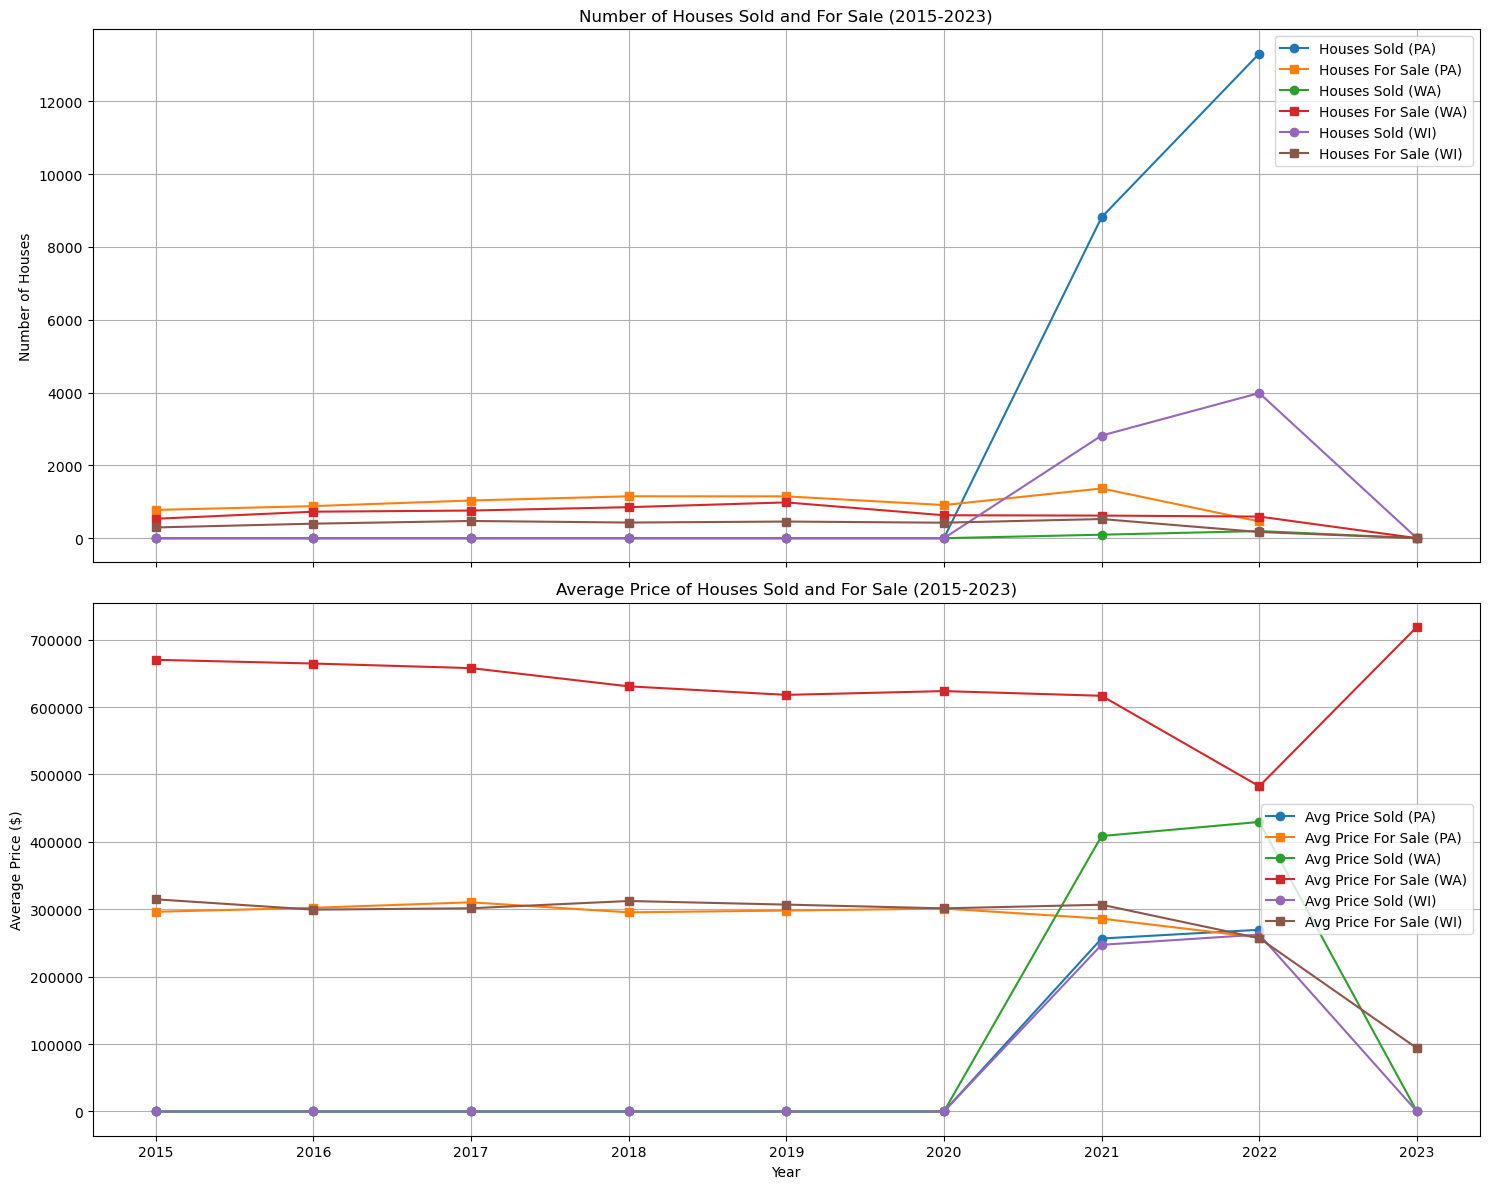

In [26]:
#buidling two comprehensive charts to display: (1) Number of Houses sold and for sale over the years in each state - 
# - (2) Average Price of Houses sold and for sale over the years in each state

# Filter data for years 2015 to 2023
def filter_data(df):
    return df[df['prev_sold_date'].dt.year.between(2015, 2023)].copy()

pa_df_2015_2023 = filter_data(pa_df_clean)
wa_df_2015_2023 = filter_data(wa_df_clean)
wi_df_2015_2023 = filter_data(wi_df_clean)

# Calculate the number of houses sold and for sale each year and their average prices
def calculate_yearly_stats(df):
    df['year'] = df['prev_sold_date'].dt.year
    sold = df[df['status'] == 'sold'].groupby('year').agg({'price': 'mean', 'status': 'count'}).rename(columns={'price': 'avg_price_sold', 'status': 'num_sold'})
    for_sale = df[df['status'] == 'for_sale'].groupby('year').agg({'price': 'mean', 'status': 'count'}).rename(columns={'price': 'avg_price_for_sale', 'status': 'num_for_sale'})
    return sold.join(for_sale, how='outer').fillna(0)

pa_stats = calculate_yearly_stats(pa_df_2015_2023)
wa_stats = calculate_yearly_stats(wa_df_2015_2023)
wi_stats = calculate_yearly_stats(wi_df_2015_2023)

# Combine data into one DataFrame
combined_stats = pd.concat([pa_stats, wa_stats, wi_stats], keys=['PA', 'WA', 'WI'], names=['State', 'Year']).reset_index()

# Plotting the data
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot number of houses sold and for sale
for state in ['PA', 'WA', 'WI']:
    state_stats = combined_stats[combined_stats['State'] == state]
    axes[0].plot(state_stats['Year'], state_stats['num_sold'], label=f'Houses Sold ({state})', marker='o')
    axes[0].plot(state_stats['Year'], state_stats['num_for_sale'], label=f'Houses For Sale ({state})', marker='s')

axes[0].set_ylabel('Number of Houses')
axes[0].set_title('Number of Houses Sold and For Sale (2015-2023)')
axes[0].legend()
axes[0].grid(True)

# Plot average prices of houses sold and for sale
for state in ['PA', 'WA', 'WI']:
    state_stats = combined_stats[combined_stats['State'] == state]
    axes[1].plot(state_stats['Year'], state_stats['avg_price_sold'], label=f'Avg Price Sold ({state})', marker='o')
    axes[1].plot(state_stats['Year'], state_stats['avg_price_for_sale'], label=f'Avg Price For Sale ({state})', marker='s')

axes[1].set_ylabel('Average Price ($)')
axes[1].set_title('Average Price of Houses Sold and For Sale (2015-2023)')
axes[1].legend()
axes[1].grid(True)

# Set common xlabel
axes[-1].set_xlabel('Year')

fig.tight_layout()
plt.savefig("image_files_2/grouped_lc.png")
plt.show()


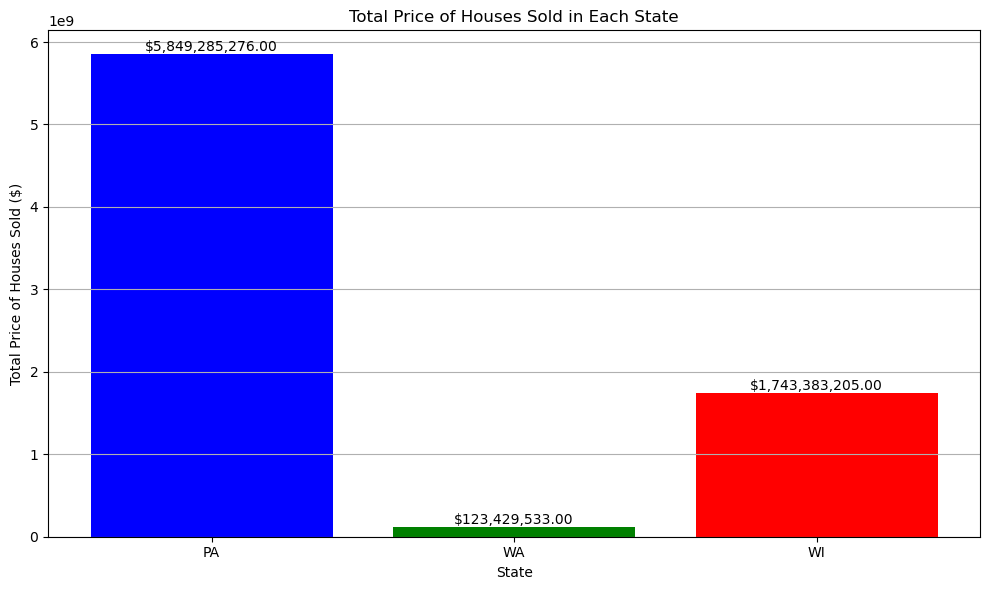

In [27]:
#Total Prices of Houses Sold in each state

# Filter data for houses sold
pa_sold = pa_df_clean[pa_df_clean['status'] == 'sold']
wa_sold = wa_df_clean[wa_df_clean['status'] == 'sold']
wi_sold = wi_df_clean[wi_df_clean['status'] == 'sold']

# Calculate the total price for houses sold in each state
total_price_sold_pa = pa_sold['price'].sum()
total_price_sold_wa = wa_sold['price'].sum()
total_price_sold_wi = wi_sold['price'].sum()

# Create a DataFrame for the total prices
total_price_sold = pd.DataFrame({
    'State': ['PA', 'WA', 'WI'],
    'Total Price Sold': [total_price_sold_pa, total_price_sold_wa, total_price_sold_wi]
})

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(total_price_sold['State'], total_price_sold['Total Price Sold'], color=['blue', 'green', 'red'])
plt.xlabel('State')
plt.ylabel('Total Price of Houses Sold ($)')
plt.title('Total Price of Houses Sold in Each State')
plt.grid(axis='y')

# Add data labels
for index, value in enumerate(total_price_sold['Total Price Sold']):
    plt.text(index, value, f'${value:,.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig("image_files_2/tp_bc.png")
plt.show()

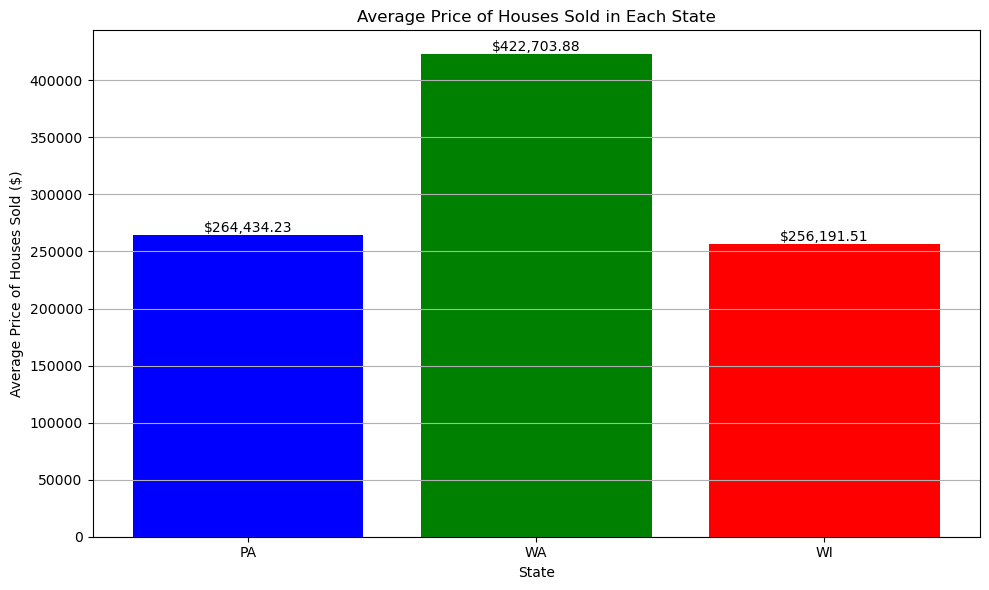

In [28]:
#Average Price of the Houses sold in each State
# Filter data for houses sold
pa_sold = pa_df_clean[pa_df_clean['status'] == 'sold']
wa_sold = wa_df_clean[wa_df_clean['status'] == 'sold']
wi_sold = wi_df_clean[wi_df_clean['status'] == 'sold']

# Calculate the average price for houses sold in each state
average_price_sold_pa = pa_sold['price'].mean()
average_price_sold_wa = wa_sold['price'].mean()
average_price_sold_wi = wi_sold['price'].mean()

# Create a DataFrame for the average prices
average_price_sold = pd.DataFrame({
    'State': ['PA', 'WA', 'WI'],
    'Average Price Sold': [average_price_sold_pa, average_price_sold_wa, average_price_sold_wi]
})

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_price_sold['State'], average_price_sold['Average Price Sold'], color=['blue', 'green', 'red'])
plt.xlabel('State')
plt.ylabel('Average Price of Houses Sold ($)')
plt.title('Average Price of Houses Sold in Each State')
plt.grid(axis='y')

# Add data labels
for index, value in enumerate(average_price_sold['Average Price Sold']):
    plt.text(index, value, f'${value:,.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig("image_files_2/ap_bc.png")
plt.show()

In [29]:
# Determining price per square foot for the listings within each state and adding the column to each state's dataframe
wi_df_clean["price/per_sqft"] = wi_df_clean["price"]/wi_df_clean["house_size"]
wa_df_clean["price/per_sqft"] = wa_df_clean["price"]/wa_df_clean["house_size"]
pa_df_clean["price/per_sqft"] = pa_df_clean["price"]/pa_df_clean["house_size"]

In [30]:
# Calculating the average price per square foot for each state
wi_sqft_mean = wi_df_clean["price/per_sqft"].mean()
wa_sqft_mean = wa_df_clean["price/per_sqft"].mean()
pa_sqft_mean = pa_df_clean["price/per_sqft"].mean()

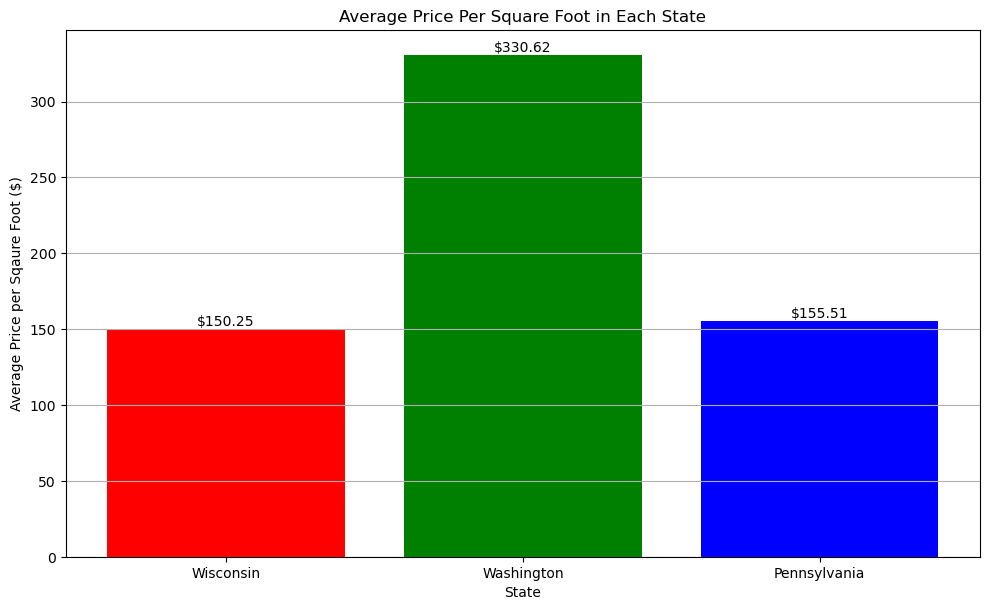

In [31]:
# Creating visualization to display price per square foot comparison between all states
states = ['Wisconsin', 'Washington', 'Pennsylvania']
sqft_means = [wi_sqft_mean, wa_sqft_mean, pa_sqft_mean]
plt.figure(figsize=(10,6))
plt.bar(states, sqft_means, color=['red', 'green', 'blue'])
plt.xlabel('State')
plt.ylabel('Average Price per Sqaure Foot ($)')
plt.grid(axis='y')
for i, mean in enumerate(sqft_means):
    plt.text(i, mean, f'${mean:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.title('Average Price Per Square Foot in Each State')
plt.savefig("image_files_2/Group_Fig3.png")
plt.show()


In [32]:
# Calculating the average number of bathrooms in each state
wi_mean_bathrooms = wi_df_clean['bath'].mean()
wa_mean_bathrooms = wa_df_clean['bath'].mean()
pa_mean_bathrooms = pa_df_clean['bath'].mean()

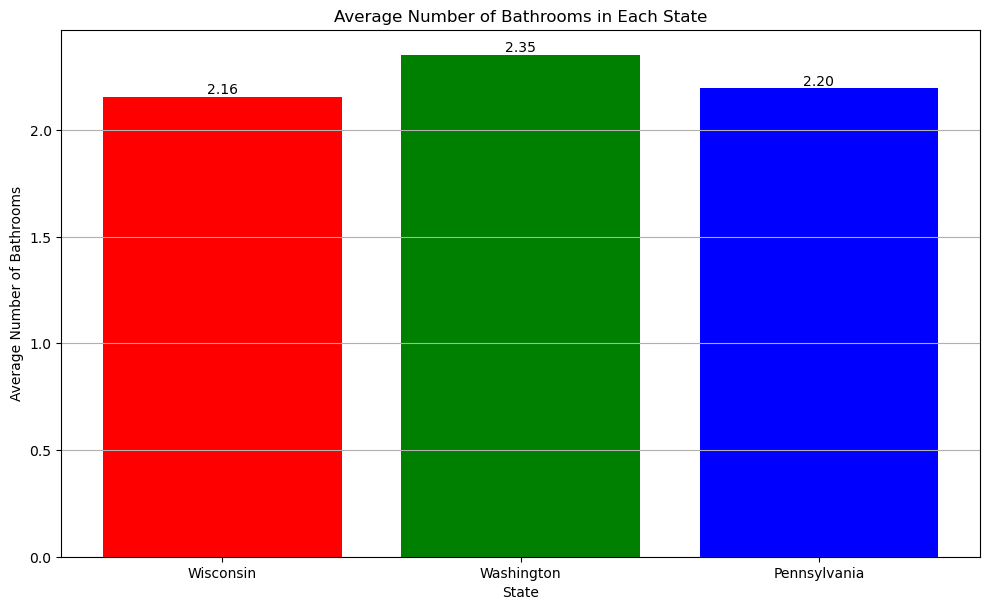

In [33]:
# Creating visualization to display average number of bathrooms comparison between all states
states = ['Wisconsin', 'Washington', 'Pennsylvania']
mean_bathrooms = [wi_mean_bathrooms, wa_mean_bathrooms, pa_mean_bathrooms]
plt.figure(figsize=(10,6))
plt.bar(states, mean_bathrooms, color=['red', 'green', 'blue'])
plt.xlabel('State')
plt.ylabel('Average Number of Bathrooms')
plt.grid(axis='y')
for i, mean in enumerate(mean_bathrooms):
    plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.title('Average Number of Bathrooms in Each State')
plt.savefig("image_files_2/Group_Fig4.png")
plt.show()


In [34]:
# Calculating the average number of bedrooms in each state
wi_mean_bedrooms = wi_df_clean['bed'].mean()
wa_mean_bedrooms = wa_df_clean['bed'].mean()
pa_mean_bedrooms = pa_df_clean['bed'].mean()

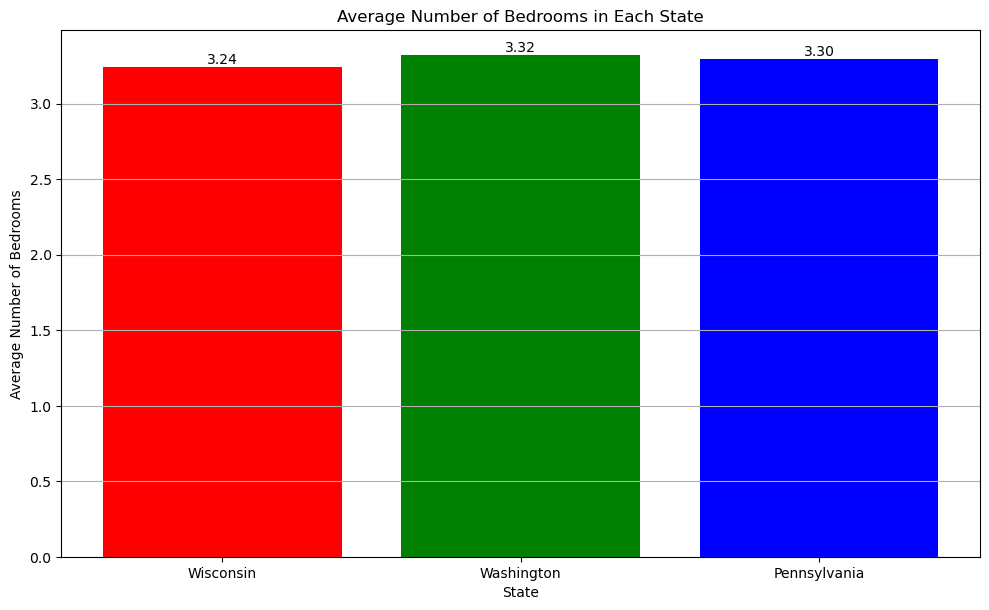

In [35]:
# Creating visualization to display average number of bedrooms comparison between all states
states = ['Wisconsin', 'Washington', 'Pennsylvania']
mean_bedrooms = [wi_mean_bedrooms, wa_mean_bedrooms, pa_mean_bedrooms]
plt.figure(figsize=(10,6))
plt.bar(states, mean_bedrooms, color=['red', 'green', 'blue'])
plt.xlabel('State')
plt.ylabel('Average Number of Bedrooms')
plt.grid(axis='y')
for i, mean in enumerate(mean_bedrooms):
    plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.title('Average Number of Bedrooms in Each State')
plt.savefig("image_files_2/Group_Fig5.png")
plt.show()


In [36]:
# Calculating the average living space for listings in each state
wi_mean_living = wi_df_clean['house_size'].mean()
wa_mean_living = wa_df_clean['house_size'].mean()
pa_mean_living = pa_df_clean['house_size'].mean()

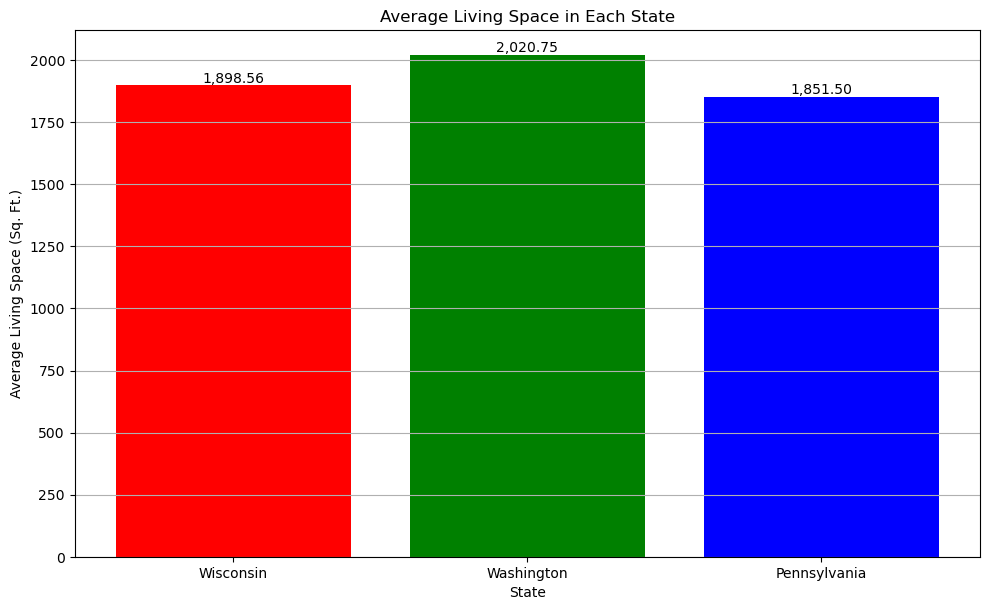

In [37]:
# Creating visualization to display average living space comparison between all states
states = ['Wisconsin', 'Washington', 'Pennsylvania']
mean_living = [wi_mean_living, wa_mean_living, pa_mean_living]
plt.figure(figsize=(10,6))
plt.bar(states, mean_living, color=['red', 'green', 'blue'])
plt.xlabel('State')
plt.ylabel('Average Living Space (Sq. Ft.)')
plt.grid(axis='y')
for i, mean in enumerate(mean_living):
    plt.text(i, mean, f'{mean:,.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.title('Average Living Space in Each State')
plt.savefig("image_files_2/Group_Fig6.png")
plt.show()


In [38]:
# Calculating the standard deviation in regards to pricing for listings in each state
wi_stddev_price = np.std(wi_df_clean['price'])
wa_stddev_price = np.std(wa_df_clean['price'])
pa_stddev_price = np.std(pa_df_clean['price'])
print("Standard Deviation of Prices for Wisconsin:", wi_stddev_price)
print("Standard Deviation of Prices for Washington:", wa_stddev_price)
print("Standard Deviation of Prices for Pennsylvania:", pa_stddev_price)

Standard Deviation of Prices for Wisconsin: 138374.87354013184
Standard Deviation of Prices for Washington: 293409.3923321002
Standard Deviation of Prices for Pennsylvania: 147015.85524638536


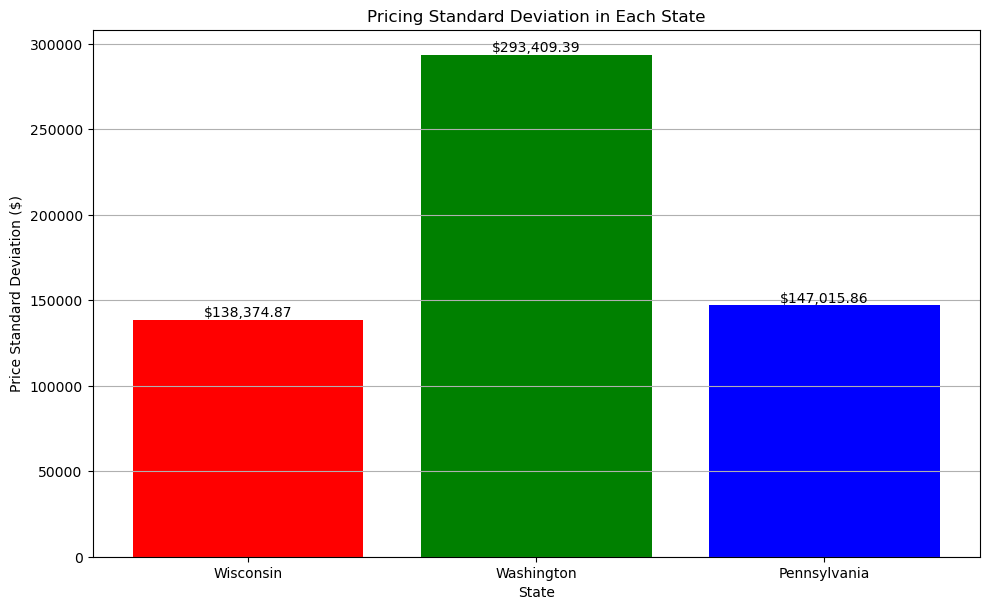

In [39]:
# Creating visualization to display pricing standard deviation comparison between all states
states = ['Wisconsin', 'Washington', 'Pennsylvania']
st_dev = [wi_stddev_price, wa_stddev_price, pa_stddev_price]
plt.figure(figsize=(10,6))
plt.bar(states, st_dev, color=['red', 'green', 'blue'])
plt.xlabel('State')
plt.ylabel('Price Standard Deviation ($)')
plt.grid(axis='y')
for i, mean in enumerate(st_dev):
    plt.text(i, mean, f'${mean:,.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.title('Pricing Standard Deviation in Each State')
plt.savefig("image_files_2/Group_Fig7.png")
plt.show()
